In [12]:
'''
    Data Driven Yale: Analytical regionalization & Social media data
        I: use Davies Bouldin clustering index to determine optimal initialization of neurons for SOM
'''

%matplotlib inline

import pandas as pd
import numpy as np
import json 
import geojson
import matplotlib.pyplot as plt 
from descartes import PolygonPatch
from pprint import pprint 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from neupy import algorithms, environment
from neupy import utils

import pandas as pd 
from sklearn.cluster import k_means
from scipy.spatial import distance

from datetime import timedelta
import warnings
warnings.filterwarnings(action='once')

In [17]:
def factors(x):
    result = []
    i = 1
    while i*i <= x:
        if x % i == 0:
            result.append(i)
            if x/i != i:
                result.append(x/i)
        i += 1
    return result

def makePQs(fs): 
    pqs = []
    # f = facts[0]
    ind = len(fs)
    if ind % 2 != 0:
        sq = fs[ind - 1]
        pqs.append((sq, sq))
        fs = fs[:-1]
        ind = ind -1
    i = 0
    while i < ind: 
        pair = (fs[i], fs[i+1])
        i += 2
        # print(pair)
        pqs.append(pair)
    return pqs

def validFacts(row): 
    dif = abs(row['f1'] - row['f2'])
    rat = np.max((row['f1'], row['f2'])) / float(dif)
    if rat < 2: 
        out = False 
    else: 
        out = True
    return out

def makePq(row, ind):
    if ind == 'p':  
        out = np.min((row['f1'], row['f2']))
    elif ind == 'q':
        out = np.max((row['f1'], row['f2']))
    return out

def makePq(row, ind):
    if ind == 'p':  
        out = np.min((row['f1'], row['f2']))
    elif ind == 'q':
        out = np.max((row['f1'], row['f2']))
    return out

def getDist(row): 
    p1 = (row['latp'], row['lonp']) 
    p2 = (row['lat'], row['lon']) 
    dst = distance.euclidean(p1, p2)
    return dst

def getDBIstd(grid_size, dfWB):
    GRID_HEIGHT = grid_size['p']
    GRID_WIDTH = grid_size['q']
    wbDat = dfWB.sample(frac=0.10, replace=False)
    wbArray = np.array(wbDat[['lon', 'lat']])
    sofm = algorithms.SOFM(
        n_inputs=2,
        features_grid=(GRID_HEIGHT, GRID_WIDTH),
        verbose=True,
        shuffle_data=True,
        distance='euclid',
        learning_radius=2,
        reduce_radius_after=20,
        std=2,
        reduce_std_after=50,
        step=0.3,
        reduce_step_after=50,
    )
    '''this takes 5 minutes'''
    sofm.train(wbArray, epochs=10)
    preds = sofm.predict(wbArray)
    dfp = pd.DataFrame(preds)
    dfp['label'] = dfp.idxmax(axis=1)
    dfp.reset_index(inplace=True)
    npd34 = sofm.weight
    npd34Lats, npd34Lons = npd34[1], npd34[0]
    coords = [] 
    for i in range(len(npd34Lats)): 
        lat, lon = npd34Lats[i], npd34Lons[i]
        out = {
            'lat' : lat, 
            'lon' : lon
        }
        coords.append(out)
        # - 
    dfcnt = pd.DataFrame(coords)
    dfcnt.reset_index(inplace=True)
    dfcnt.columns = ['label', 'lat', 'lon']
    dflab = pd.merge(dfp, dfcnt, on='label', how='outer')
    wbdf = pd.DataFrame(wbArray, columns=['lonp', 'latp'])
    wbdf.reset_index(inplace=True)
    dfDB = pd.merge(dflab, wbdf, on='index', how='outer')
    dfDB['euclidean_dist'] = dfDB.apply(lambda row: getDist(row), axis=1)
    average_distance = dfDB.groupby('label').agg({'euclidean_dist' : np.std})
    average_distance.reset_index(inplace=True)
    dbframe = pd.merge(average_distance, dfcnt, on='label', how='outer')
    Ri = []
    for i in range(len(dbframe)): 
        Rij = [] 
        cnt = dbframe.iloc[i]
        p1 = (cnt['lat'], cnt['lon']) 
        mean_dist = cnt['euclidean_dist']
        for j in range(len(dbframe)): 
            if j != i: 
                cnt2 = dbframe.iloc[j]
                p2 = (cnt2['lat'], cnt2['lon'])
                mean_dist2 = cnt2['euclidean_dist']
                r = (mean_dist + mean_dist2) / distance.euclidean(p1, p2)
                Rij.append(r)
                # - 
        Ri.append(max(Rij))
        # - 
    print('found dbi for grid_size')
    dbi = np.mean(Ri)
    return dbi


In [8]:
with open("../data/beijing.geojson") as json_file:
    json_data = geojson.load(json_file)

dfWB = pd.read_csv('../data/inLabelRegionPoints.csv')

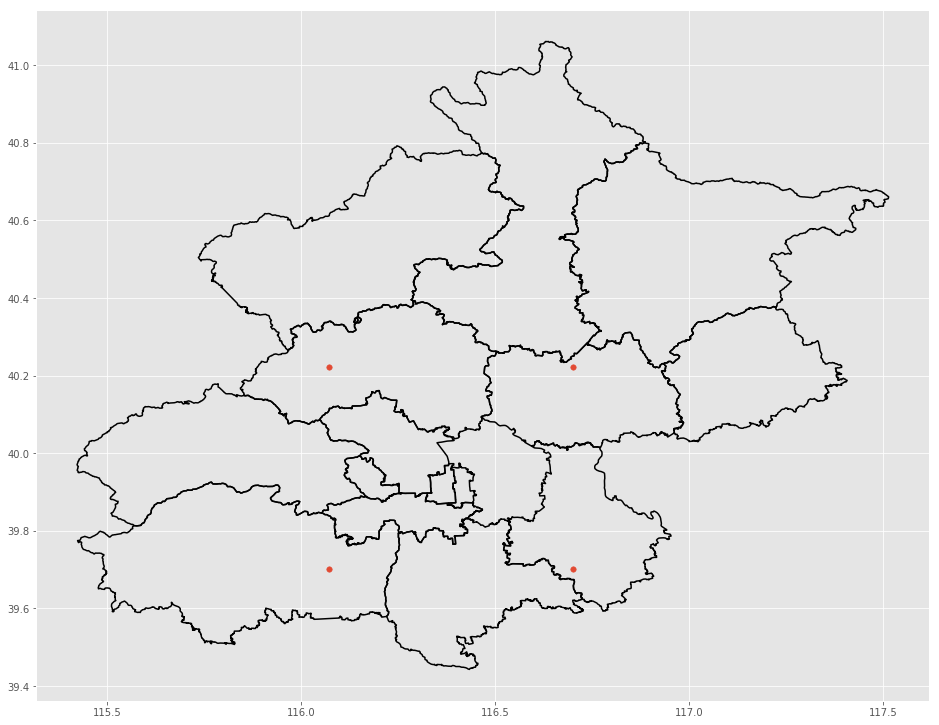

In [36]:
maxLon, minLon = np.max(dfWB['lon']), np.min(dfWB['lon'])
maxLat, minLat = np.max(dfWB['lat']), np.min(dfWB['lat'])

corners = [(minLon, maxLat), (maxLon, maxLat), (maxLon, minLat), (minLon, minLat)]
dfCorners = pd.DataFrame(corners)
dfCorners.columns = ['lon', 'lat']

# plot geojson region to show corners 
fig = plt.figure(figsize=(16,16))
feats = json_data['features']
for i in range(0, len(feats)): 
    try: 
        test = feats[i]
        poly = test['geometry']
        coords = poly['coordinates']
        x = [i for i,j in coords[0]]
        y = [j for i,j in coords[0]]
        ax = fig.gca() 
        ax.plot(x, y, color='black')
        ax.axis('scaled')
    except: 
        continue

# plot corners of ROI over beijing geojson
plt.scatter(dfCorners['lon'], dfCorners['lat'], s=30)
plt.show()

width = maxLon - minLon
height = maxLat - minLat
ratio = np.float(height) /np.float(width)

In [19]:
# -- 
# get factors of all desired grid sizes

N = []
for i in range(10, 101): 
    N.append(i)

facts = [factors(i) for i in N]

# --
# make pairs of valid factors based on N

pQs = []
for i in range(len(facts)): 
    # print(i)
    pQs.extend(makePQs(facts[i]))

In [30]:
warnings.filterwarnings('ignore')
df_factor = pd.DataFrame(pQs)
df_factor.columns = ['f1', 'f2']
df_factor = df_factor.loc[(df_factor['f1'] != 1) & (df_factor['f2'] != 1)]

df_factor['valid'] = df_factor.apply(lambda row: validFacts(row), axis=1)
valid = df_factor.loc[df_factor['valid'] == True]
valid['checkSum'] = valid.apply(lambda row: row['f1'] * row['f2'], axis=1)

valid['p'] = valid.apply(lambda row: makePq(row, 'p'), axis=1)
valid['q'] = valid.apply(lambda row: makePq(row, 'q'), axis=1)
valid['checkAlign'] = valid.apply(lambda row: row['p'] <= row['q'], axis=1)

In [31]:
valid.reset_index(inplace=True)

outDicts = []
for i in range(len(valid)): 
    try: 
        # print('evaluating ' + str(i) + ' of ' + str(len(valid)) + 'initializing grids')
        instance = valid.iloc[i][['index','p', 'q']]
        dbi = getDBIstd(instance, dfWB)
        outDicts.append({
                'index' : instance['index'], 
                'p' : instance['p'], 
                'q' : instance['q'],
                'dbi' : dbi
            })
    except: 
        print('failed on index ' + str(i))




Main information

[ALGORITHM] SOFM

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] step = 0.3
[OPTION] train_end_signal = None
[OPTION] n_inputs = 2
[OPTION] distance = euclid
[OPTION] features_grid = [3, 4]
[OPTION] grid_type = rect
[OPTION] learning_radius = 2
[OPTION] n_outputs = None
[OPTION] reduce_radius_after = 20
[OPTION] reduce_std_after = 50
[OPTION] reduce_step_after = 50
[OPTION] std = 2
[OPTION] weight = Normal(mean=0, std=0.01)


Start training

[TRAINING DATA] shapes: (16465, 2)
[TRAINING] Total epochs: 10

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           1 |    0.086353 |           - |       3 sec |
|           2 |    0.060265 |           - |       4 sec |
|           3 |    0.059901 |           - |       3 sec |
|           4 |    0.060013 |           - |       4

|           5 |     0.04861 |           - |       3 sec |
|           6 |    0.048513 |           - |       3 sec |
|           7 |    0.048507 |           - |       3 sec |
|           8 |    0.048236 |           - |       3 sec |
|           9 |    0.048189 |           - |       3 sec |
|          10 |    0.048134 |           - |       3 sec |
---------------------------------------------------------

found dbi for grid_size

Main information

[ALGORITHM] SOFM

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] step = 0.3
[OPTION] train_end_signal = None
[OPTION] n_inputs = 2
[OPTION] distance = euclid
[OPTION] features_grid = [5, 5]
[OPTION] grid_type = rect
[OPTION] learning_radius = 2
[OPTION] n_outputs = None
[OPTION] reduce_radius_after = 20
[OPTION] reduce_std_after = 50
[OPTION] reduce_step_after = 50
[OPTION] std = 2
[OPTION] weight = Normal(mean=0, std=0.01)


Start training

[TRAINING DATA] shapes: (16465, 

|           1 |      0.1104 |           - |       4 sec |
|           2 |    0.043928 |           - |       4 sec |
|           3 |    0.043687 |           - |       3 sec |
|           4 |    0.043729 |           - |       4 sec |
|           5 |    0.043697 |           - |       4 sec |
|           6 |    0.043405 |           - |       4 sec |
|           7 |    0.043243 |           - |       4 sec |
|           8 |    0.043314 |           - |       4 sec |
|           9 |    0.043283 |           - |       4 sec |
|          10 |    0.043049 |           - |       4 sec |
---------------------------------------------------------

found dbi for grid_size

Main information

[ALGORITHM] SOFM

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] step = 0.3
[OPTION] train_end_signal = None
[OPTION] n_inputs = 2
[OPTION] distance = euclid
[OPTION] features_grid = [5, 8]
[OPTION] grid_type = rect
[OPTION] learning_radius = 2
[

|           1 |     0.11316 |           - |       4 sec |
|           2 |    0.037775 |           - |       4 sec |
|           3 |    0.037675 |           - |       3 sec |
|           4 |    0.037546 |           - |       4 sec |
|           5 |    0.037509 |           - |       4 sec |
|           6 |    0.037425 |           - |       3 sec |
|           7 |    0.037378 |           - |       3 sec |
|           8 |    0.037291 |           - |       4 sec |
|           9 |    0.037101 |           - |       3 sec |
|          10 |    0.037113 |           - |       4 sec |
---------------------------------------------------------

found dbi for grid_size

Main information

[ALGORITHM] SOFM

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] step = 0.3
[OPTION] train_end_signal = None
[OPTION] n_inputs = 2
[OPTION] distance = euclid
[OPTION] features_grid = [6, 9]
[OPTION] grid_type = rect
[OPTION] learning_radius = 2
[

|           1 |     0.12975 |           - |       3 sec |
|           2 |    0.034565 |           - |       3 sec |
|           3 |     0.03434 |           - |       3 sec |
|           4 |    0.034354 |           - |       3 sec |
|           5 |    0.034252 |           - |       3 sec |
|           6 |    0.034108 |           - |       3 sec |
|           7 |    0.034104 |           - |       3 sec |
|           8 |     0.03394 |           - |       3 sec |
|           9 |    0.034046 |           - |       3 sec |
|          10 |    0.033892 |           - |       3 sec |
---------------------------------------------------------

found dbi for grid_size

Main information

[ALGORITHM] SOFM

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] step = 0.3
[OPTION] train_end_signal = None
[OPTION] n_inputs = 2
[OPTION] distance = euclid
[OPTION] features_grid = [7, 10]
[OPTION] grid_type = rect
[OPTION] learning_radius = 2


|           1 |     0.14667 |           - |       3 sec |
|           2 |    0.032535 |           - |       3 sec |
|           3 |    0.032442 |           - |       3 sec |
|           4 |    0.032372 |           - |       3 sec |
|           5 |    0.032285 |           - |       3 sec |
|           6 |    0.032264 |           - |       3 sec |
|           7 |    0.032273 |           - |       3 sec |
|           8 |    0.031967 |           - |       3 sec |
|           9 |     0.03164 |           - |       3 sec |
|          10 |    0.031883 |           - |       3 sec |
---------------------------------------------------------

found dbi for grid_size

Main information

[ALGORITHM] SOFM

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] step = 0.3
[OPTION] train_end_signal = None
[OPTION] n_inputs = 2
[OPTION] distance = euclid
[OPTION] features_grid = [7, 12]
[OPTION] grid_type = rect
[OPTION] learning_radius = 2


|           1 |     0.17143 |           - |       3 sec |
|           2 |    0.029526 |           - |       3 sec |
|           3 |    0.029217 |           - |       3 sec |
|           4 |    0.029302 |           - |       4 sec |
|           5 |    0.029204 |           - |       4 sec |
|           6 |    0.029125 |           - |       4 sec |
|           7 |    0.029094 |           - |       4 sec |
|           8 |    0.028962 |           - |       4 sec |
|           9 |    0.028945 |           - |       4 sec |
|          10 |    0.028862 |           - |       4 sec |
---------------------------------------------------------

found dbi for grid_size

Main information

[ALGORITHM] SOFM

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] step = 0.3
[OPTION] train_end_signal = None
[OPTION] n_inputs = 2
[OPTION] distance = euclid
[OPTION] features_grid = [9, 11]
[OPTION] grid_type = rect
[OPTION] learning_radius = 2


In [37]:
dfDBI = pd.DataFrame(outDicts)
dfDBI.head()

,dbi,index,p,q
0,6.978076,5,3,4
1,3.621300,10,3,5
2,4.920536,11,4,4
3,2.773312,17,3,6
4,2.644506,21,4,5


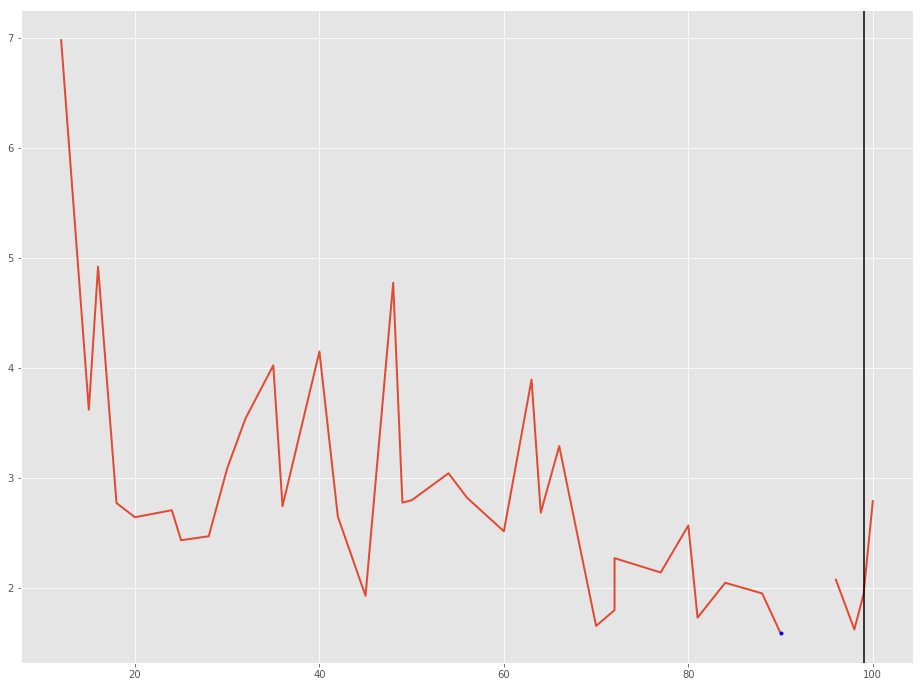

In [43]:
# plot grid size over number of neurons from SOM init
dfDBI['grid_size'] = dfDBI.apply(lambda row: row['p'] * row['q'], axis=1)

min_score = dfDBI.dbi.min()
min_init = dfDBI.loc[dfDBI['dbi'] == min_score]
x = min_init['grid_size']
y = min_init['dbi']

fig = plt.figure(figsize=(16,12))
plt.plot(dfDBI['grid_size'], dfDBI['dbi'], linewidth=2.0)
plt.plot(x, y, marker='o', markersize=3, color="blue")
plt.axvline(x=99, color='black')
plt.show()

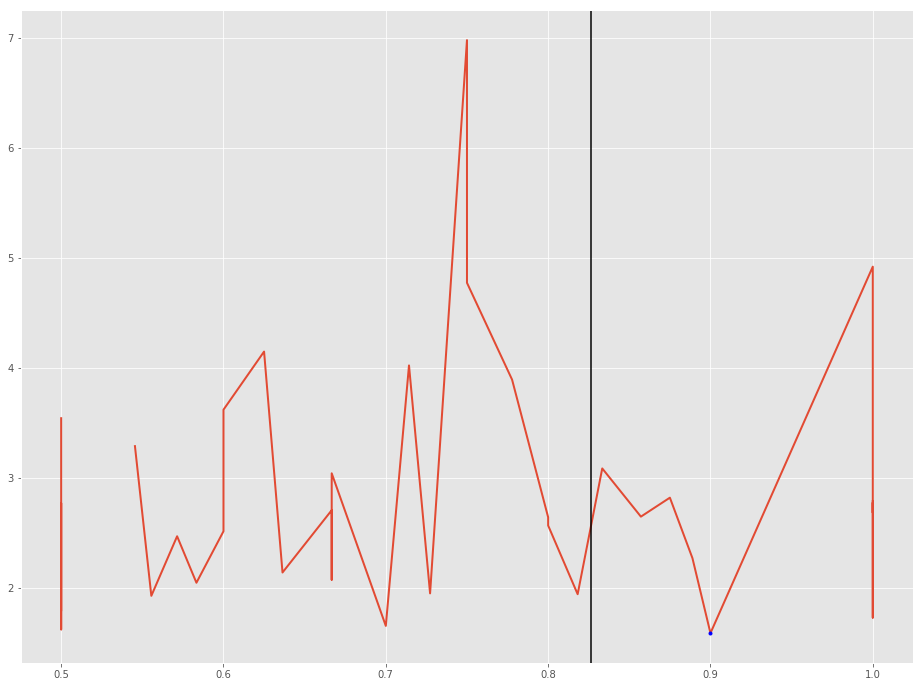

In [44]:
dfDBI['ratio'] = dfDBI.apply(lambda row: np.float(row['p']) / np.float(row['q']), axis=1)

min_score = dfDBI.dbi.min()
min_init = dfDBI.loc[dfDBI['dbi'] == min_score]
x = min_init['ratio']
y = min_init['dbi']

dfDBI = dfDBI.sort_values('ratio')

fig = plt.figure(figsize=(16,12))
plt.plot(dfDBI['ratio'], dfDBI['dbi'], linewidth=2.0)
plt.plot(x, y, marker='o', markersize=3, color="blue")
plt.axvline(x=ratio, color='black')